# Final Project:  Spam filter

## Task

You’re the project manager for an enterprise email system and assigned a task to develop a spam filter for a company's email system. We’ve collected email samples that have been validated to be spam or non-spam emails. Your task is to predicts whether an email contains spam or not.

You are given 3068 training emails with two classes: "spam" or "not spam". Using these data, you are expected to build your own spam filter with the kownledge you learned from this course. The goal is to correctly classify 1292 test emails. 




### Example
- **Spam email**

> Subject: younger and healthier with ultimate - hghl 7283  as seen on nbc , cbs , cnn , and even oprah ! the health discovery that actuallyreverses aging while burning fat , without dieting or exercise ! this provendiscovery has even been reported on by the new england journal of medicine . forget aging and dieting forever ! and it ' s guaranteed !  click below to enter our web site :  http : / / www . freehostchina . com / washgh /  would you like to lose weight while you sleep !  no dieting !  no hunger pains !  no cravings !  no strenuous exercise !  change your life forever !  100 % guaranteed !  1 . body fat loss 82 % improvement .  2 . wrinkle reduction 61 % improvement .  3 . energy level 84 % improvement .  4 . muscle strength 88 % improvement .  5 . sexual potency 75 % improvement .  6 . emotional stability 67 % improvement .  7 . memory 62 % improvement .  click below to enter our web site :  http : / / www . freehostchina . com / washgh /  if you want to get removed  from our list please email at - standardoptout @ x 263 . net ( subject = remove " your email " )

- **Not-spam email**

> Subject: december 6 th meeting  dear mr . kaminski :  this is to confirm the december 6 th meeting here at our center .  the location for the meeting is room # 3212 steinberg hall - dietrich hall and  the time will run from 9 : 00 am - 11 : 00 am .  please let us know if you need anything further .  we look forward to seeing you then .  regards ,  theresa convery  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  theresa convery  administrative assistant  risk and decision processes center  the wharton school of the university of pennsylvania  ( 215 ) 898 - 5688 / fax : ( 215 ) 573 - 2130  tconvery @ wharton . upenn . edu

## Outline of solution


**1. Text representation.**

As you can see, text content of emails is unstructured data. To apply machine learning methods on top of them, we first need to extract structured feature. To demonstrate this, we'll show using bag-of-word model for textural represention.

** 2. Build your classifier. **

As baseline, we provide solution based on *SVM* (Support Vector Machine).

** 3. Evaluation **

We will use *AP* (Average Precision) and *Accuracy* for performance evaluation in this notebook.

Note that for evaluation on kaggle competition, [*MCE*](https://www.kaggle.com/wiki/MeanConsequentialError) (Mean Consequential Error) is used instead.


## Python package dependence
- **pandas**   : for loading CSV files;
- **nltk**     ：for word pre-processing;
- **wordcloud**: for data visulization.

Tips: To install missing packages, you can either do "pip install package_name" or "conda install package_name" in case of anaconda.

# Data preparation

## 1) Download data.

Download "emails.train.csv", "emails.test.csv" from our kaggle competition page [here](https://www.kaggle.com/c/spamfilter-aml-uva/data), and put it under the same folder as this ipython notebook.



## 2) Read in data.

In [1]:
import os, sys
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

assert os.path.exists('./emails.train.csv'), "[Dataset File Not Found] Please download dataset first."

In [2]:
# Read in csv file as dataframe
df = pd.read_csv('./emails.train.csv')

# Show a snippet of dataset.
df.head()

,id,text,spam
0,0,Subject: naturally irresistible your corporate...,1
1,2,Subject: unbelievable new homes made easy im ...,1
2,3,Subject: 4 color printing special request add...,1
3,4,"Subject: do not have money , get software cds ...",1
4,5,"Subject: great nnews hello , welcome to medzo...",1


As you can see above, each emails has two fields: 
* "text": the full text content of an email.
* "spam": an integer flag to mark whether an email is a spam (=1) or not (=0).

In [3]:
print("===========================")
print("Example of spam emails")
print("---------------------------")

df_pos = df[df['spam']==1]

print( np.random.choice(df_pos['text']) ) 

print("===========================")

Example of spam emails
---------------------------
Subject: the best possible mortgage  has your mortgage search got you down ?  are you frustrated and confused with all the different terms and quotes ? don ' t  know who is telling you the truth ? we can solve all your problems .  visit our site today and in two minutes you can have us searching thousands of  programs and lenders for you . get the truth , get the facts , get your options  all in one shot . it ' s absolutely free , and you can be done in only two minutes ,  so click right now and put your worries behind you !  [ ryte ^ 3247 ( ^ ( pol : kj ) _ 8 j 7 bjk ]


In [4]:
print("===========================")
print("Example of not spam emails")
print("---------------------------")

df_neg = df[df['spam']==0]

print( np.random.choice(df_neg['text']) ) 

print("===========================")

Example of not spam emails
---------------------------
Subject: presentation on metals  - - - - - - - - - - - - - - - - - - - - - - forwarded by leann walton / na / enron on 10 / 26 / 2000 10 : 52  am - - - - - - - - - - - - - - - - - - - - - - - - - - -  alison sealy on 10 / 09 / 2000 10 : 37 : 40 am  to : mraymon @ enron . com  cc :  subject : presentation on metals  hi maureen ,  it was good to meet you last week and hear your presentation on the metals -  full of advice on what to think about and all the various things that affect  the market place . i am only sorry i had to dash off to the airport - good  job i left when i did though as check - in took ages !  anyway , please could you send me through a copy of that presentation either  on email or if it is located on the network somewhere then i could access it  over the intranet ? i will be joining the lme conference tomorrow so am  currently trying to do a bit of reading in preparation .  thanks very much in advance & look forw

# Text representation

## 1) Create the bags of words vocabulary. 

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The bag-of-words model has also been used for computer vision. (from [wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model))


In [5]:
def select_vocabulary(dataframe, topN=100):
    # for w in dataframe.str.lower():
    word2freq = dict()
    for line in dataframe:
        words = line.split()
        for word in words:
            word2freq[word] = word2freq.setdefault(word, 0) +1

    word_freq = [ (word,freq) for word,freq in word2freq.iteritems() ]
    
    # sort according to freq, in descending order.
    word_freq.sort(key=lambda x:x[1], reverse=True) 
    
    # show selection results
    print("%-10s  %10s" % ('word', 'frequency'))
    print("-------------------------")
    for i in range(15):
        print("%-10s  %10d" % (word_freq[i]))
    print("...\n")
    return([x[0] for x in word_freq[:topN]])

vocabulary = select_vocabulary(df['text'])
word2ind   = dict(zip(vocabulary, range(len(vocabulary))))

word         frequency
-------------------------
-                72932
.                65233
,                42792
the              34362
:                29814
to               28822
/                27959
and              19173
of               16317
>                14658
a                13894
you              13305
in               12631
i                12151
for              11639
...



## 2) Extract Bag-of-Word Feature

In [6]:
print vocabulary

['-', '.', ',', 'the', ':', 'to', '/', 'and', 'of', '>', 'a', 'you', 'in', 'i', 'for', '_', '@', 'enron', 'is', 'on', 'ect', ')', "'", 'this', '?', '(', 'be', 'that', 'your', '"', 'with', 'we', 'vince', '*', 'will', 'have', 'at', 'from', 'it', 'are', 's', 'as', 'Subject:', 'hou', 'com', 'by', 'or', 'if', '!', 'am', '2000', 'please', 'kaminski', 'subject', 'me', 'would', 'not', 'our', 'can', 're', '$', 'cc', 'my', 'j', 'an', '1', '=', 'pm', '2', '2001', 'all', 'research', 'any', 'time', '10', 'do', 'thanks', 'know', ';', 'has', '3', 'may', 'information', 'group', 'about', 'e', 'new', 'he', '0', 'energy', 'was', 'more', 'get', 'like', '00', 'business', 'risk', 'one', 'but', 'up']


In [7]:
def extract_Bag_of_Word_feature(dataframe):
    BoWs = np.zeros((len(dataframe), len(vocabulary)), dtype=np.float32)

    for i, line in enumerate(dataframe):
        for word in line.split():
            word_ind = word2ind.get(word, -1)
            if(word_ind>=0):
                BoWs[i, word_ind] += 1

        if i%1000==0:
            print("%4d / %d " % (i, len(dataframe)))
    print("%4d / %d " % (i, len(dataframe)))
            
    return BoWs


# Make sure use cleaned version
train = pd.read_csv('./emails.train.csv')
test  = pd.read_csv('./emails.test.csv')

# Get labels
Y_train = train['spam']
Y_test  = test['spam']

print("Extracting feature for train ...")
X_train = extract_Bag_of_Word_feature(train['text'])

print("Extracting feature for test ...")
X_test  = extract_Bag_of_Word_feature(test[ 'text'])

print('Finish.')

Extracting feature for train ...
   0 / 4021 
1000 / 4021 
2000 / 4021 
3000 / 4021 
4000 / 4021 
4020 / 4021 
Extracting feature for test ...
   0 / 1707 
1000 / 1707 
1706 / 1707 
Finish.


# Baseline solution

In [8]:
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.svm import SVC

model = SVC()

model.fit(X_train, Y_train)

def eval(model, X_test, Y_test, method=''):
    print("====== Performance of: {method} =======".format(method=method))
    
    # Predict decision labels.
    Y_pred  = model.predict(X_test)  
    print("Metric[{metric:20s}]  {score:-3f}".format( metric="Accuracy", 
                                              score=accuracy_score(Y_test, Y_pred)) )

    # Predict confidence scores.
    Y_score = model.decision_function(X_test)    
    print("Metric[{metric:20s}]  {score:-3f}".format( metric="Average Precision", 
                                              score=average_precision_score(Y_test, Y_score)) )

    # write to submit format
    outf = 'kaggle_data/solution.%s.csv'% method
    with open( outf, 'w') as f:
        f.write('id,spam\n')
        for i in range(len(Y_pred)):
            # print test['id'][0]
            f.write('%s,%s\n' % (test['id'][i], Y_pred[i]) )
    print("[output] "+outf)
    
    
# evaluate current model
eval(model, X_test, Y_test, method='SVM')

====== Performance of: SVM =======
Metric[Accuracy            ]  0.915056
Metric[Average Precision   ]  0.938815
[output] kaggle_data/solution.SVM.csv


Notice that the positive and negative examples in test is not balance (with Nr(pos)=1707, Nr(neg)=415 )

In [9]:

# Predict all labels as negative (=0)
print("====== Predict as all negative =======")
Y_pred_all_neg  = np.zeros((len(Y_test),), dtype=np.int)
print("Metric[{metric:20s}]  {score:-3f}".format( metric="Accuracy", 
                                          score=accuracy_score(Y_test, Y_pred_all_neg)) )

# Random guess performance
print("====== Predict by random guess =======")
Y_score_rand = np.random.uniform(0,1, (len(Y_test),))    # Generate prediction score by random
print("Metric[{metric:20s}]  {score:-3f}".format( metric="Average Precision", 
                                              score=average_precision_score(Y_test, Y_score_rand)) )



====== Predict as all negative =======
Metric[Accuracy            ]  0.756883
====== Predict by random guess =======
Metric[Average Precision   ]  0.240571



# Advanced: Data Preprocess

However, obtaining good textural representation can be tricky as you may notice that the content of emails are noisy.
We'll provide example code for text cleaning and you are expected to come up with smarter way to do it.

## Text cleaning

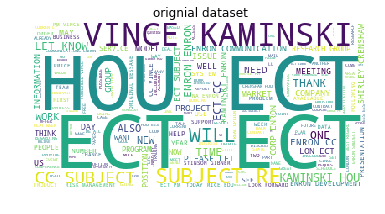

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

def wordcloud(dataframe, title=None):
    wordcloud = WordCloud(background_color="white").generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    if title is not None:
        plt.title(title)

# show the word cloud of orignial dataset.
wordcloud(df['text'], 'orignial dataset')

- ### **Stop words** 
 Stop Words are words which do not contain important significance to be used in Search Queries. For example, 'a', 'the', 'is', 'as', etc. Usually these words need to be filtered out because they return vast amount of unnecessary information. 

- ### **Stemming**
 In linguistic morphology and information retrieval, stemming is the process for reducing inflected (or sometimes derived) words to their stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. Algorithms for stemming have been studied in computer science since the 1960s. Many search engines treat words with the same stem as synonyms as a kind of query expansion, a process called conflation.

 Stemming programs are commonly referred to as stemming algorithms or stemmers.

- ### **Lemmatization**
 Lemmatisation (or lemmatization) in linguistics, is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.

 In computational linguistics, lemmatisation is the algorithmic process of determining the lemma for a given word. Since the process may involve complex tasks such as understanding context and determining the part of speech of a word in a sentence (requiring, for example, knowledge of the grammar of a language) it can be a hard task to implement a lemmatiser for a new language.

 In many languages, words appear in several inflected forms. For example, in English, the verb ‘to walk’ may appear as ‘walk’, ‘walked’, ‘walks’, ‘walking’. The base form, ‘walk’, that one might look up in a dictionary, is called the lemma for the word. The combination of the base form with the part of speech is often called the lexeme of the word.

 Lemmatisation is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

We’ll use python package *nltk* to do this. But before any operation, we need to download necessary nltk corpuses first with its interface.

In [11]:
# Download nltk corpus
import nltk

In [12]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

| Instal Wordnet corpus                | Instal Stopwords corpus                |
| ------------------------------------ |:--------------------------------------:|
| ![alt text](images/nltk_wordnet.png) | ![alt text](images/nltk_stopwords.png) |




In [14]:
def text_regularize(dataframe, method='lemm'):
    print('Performing: %s ...' % method)
    def stemming(worker, tag):
        return worker.stem(tag)

    def lemmatize(worker, tag):
        return worker.lemmatize(tag)

    if   method=='stem':
        worker = nltk.PorterStemmer()
        func = stemming
    elif method=='lemm':
        worker = nltk.WordNetLemmatizer()
        func = lemmatize
    else:
        raise NotImplementedError

    for i, line in enumerate(dataframe['text']):
        elems = line.strip().split()

        # apply stemming or lemmatize
        newtags = [func(worker,tag.lower()) for tag in elems]
        newline = " ".join(newtags)

        # update text
        dataframe.loc[i,'text'] = newline

    # return dataframe

def text_filtering(dataframe, extras=set()):
    print('Performing: filtering ...')
    import re
    
    from nltk.corpus import stopwords
    filter_set = set(stopwords.words('english'))
    filter_set.update(extras)

    for i, line in enumerate(dataframe['text']):
        # remove special characters with regex
        line = re.sub(r'[^\w]', ' ', line)

        # remove digits with regex
        line = re.sub("(^|\W)\d+($|\W)", " ", line)

        # remove stop words
        elems = line.strip().split()
        newtags = filter(lambda x: x not in filter_set, elems)
        newline = " ".join(newtags)

        # update text
        dataframe.loc[i, 'text'] = newline
    # return dataframe
    

print('========= Clearn tranining data ==========')
# Read in training data
df = pd.read_csv('./emails.train.csv')

# Do cleaning
text_regularize(df, 'lemm')
text_regularize(df, 'stem')
text_filtering(df, extras=set(['subject', 'ect', 'hou', '_']))

# Save as new file
df.to_csv('emails_clean.train.csv')


print('========= Clearn testing data ==========')
# Read in testing data
df = pd.read_csv('./emails.test.csv')

# Do cleaning
text_regularize(df, 'lemm')
text_regularize(df, 'stem')
text_filtering(df, extras=set(['subject', 'ect', 'hou', '_']))

# Save as new file
df.to_csv('emails_clean.test.csv')

print('finish')

========= Clearn tranining data ==========
Performing: lemm ...
Performing: stem ...
Performing: filtering ...
========= Clearn testing data ==========
Performing: lemm ...
Performing: stem ...
Performing: filtering ...
finish


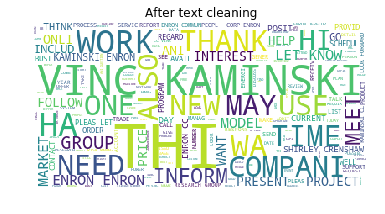

In [15]:
# Now show the word cloud after cleaning.
wordcloud(df['text'], 'After text cleaning')

# Based on the observation from this word cloud, you may add more non-meaningful words into `extras'. 

In [18]:

train = pd.read_csv('./emails_clean.train.csv')
test  = pd.read_csv('./emails_clean.test.csv')

# Get labels
Y_train = train['spam']
Y_test  = test[ 'spam']


print("[TODO] Preparing text feature.")
#############################
#####  Your solution    #####
#############################



print("[TODO] Training your model.")
#############################
#####  Your solution    #####
#############################



print("[TODO] Evaluate your model.")
#############################
#####  Your solution    #####
#############################





[TODO] Preparing text feature.
[TODO] Training your model.
[TODO] Evaluate your model.
